In [1]:
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../

# LR Analysis

This notebook analyze the LR properties of a system. It assumes that the TDDFT-BigDFT computation has already been performed.

## Analysis of the $CO$ molecule

In [3]:
norbCO = 5
pathCO = 'CO/linear-response/'
CO = build_syst_dict(pathCO, norbCO)
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


Solve the Casida eigenproblems using naSmall virtual orbitals. In this example the choice naSmall = nvirt is performed but the actual number of virtual orbitals can be reduced to check the convergence of the results w.r.t. the 
dimension of the basis in the empty-state subspace.

In [5]:
naSmall = [280]

In [6]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 280


#### Dynamical polarizability

In [7]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  280
numpoint =  336  omegaMax (eV) =  45.8183849825
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  280
numpoint =  434  omegaMax (eV) =  59.1066901023


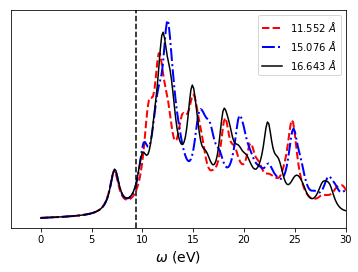

In [13]:
%matplotlib inline
syst = CO_spectrum
part = 'imagPart' #use 'realPart' to plot the real part of the dynamical polarizability
size = str(CO[7.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[7.0]['omega'],syst[7.0][part],'--',c='red',linewidth=2,label= size + ' $\AA$')
size = str(CO[9.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[9.0]['omega'],syst[9.0][part],'-.',c='blue',linewidth=2,label= size + ' $\AA$')
size = str(CO[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[10.0]['omega'],syst[10.0][part],'-',c='black',linewidth=1.5,label= size + ' $\AA$')
plt.xlim(xmax=30)
plt.yticks([])
plt.xlabel(r'$\omega$ (eV)',size = 14)
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.legend(loc='best')
plt.show()

### Excitations

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  